In [7]:
import numpy as np
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
from utils import parse_m_file, compute_PTDF


np.set_printoptions(precision=3, suppress=True, floatmode='fixed')


In [14]:
from oct2py import Oct2Py

# Start Octave session
oc = Oct2Py()

# Load the MATPOWER case file
oc.eval("addpath('/Users/don_williams09/Downloads/Bi_Level_Opt/test_cases')")  # Adjust path to the folder containing the file
mpc = oc.case118()

# Extract data
bus_data = mpc['bus']
gen_data = mpc['gen']
branch_data = mpc['branch']
gencost_data = mpc['gencost']


slack = int(bus_data[bus_data[:, 1] == 3, 0][0])
print(f"Slack bus: {slack}")

# Show dimensions or samples
print(f"Bus data shape : {bus_data.shape} ")
print(f" Generator data shape : {gen_data.shape}")
print(f" Branch data shape : {branch_data.shape} ")
print(f" Gencost data shape : {gencost_data.shape}")

num_buses = bus_data.shape[0]
num_generators = gen_data.shape[0]
num_lines = branch_data.shape[0]
num_branches = branch_data.shape[0]

# Data Extraction
Pd_base = bus_data[:, 2]
Pg_min = gen_data[:, 9]
Pg_max = gen_data[:, 8]
# Pg_max[0] = 400
# Pg_max[1] = 100
cost_coeff_true = gencost_data[:, 5]

branch_data_congested = branch_data.copy()
#branch_data_congested[:, 5] *= 0.7  # reduce limits by 30%

# PTDF = compute_PTDF(branch_data, bus_data)

def compute_PTDF(branch_data, bus_data, slack_bus=slack):
    """ Compute PTDF matrix given branch and bus data (MATPOWER format) """

    # Map bus IDs to matrix indices
    bus_ids = bus_data[:, 0].astype(int)
    id_to_index = {bus_id: idx for idx, bus_id in enumerate(bus_ids)}

    num_buses = len(bus_ids)
    num_lines = branch_data.shape[0]

    # Admittance matrix (B)
    B = np.zeros((num_buses, num_buses))
    for f_id, t_id, x in zip(branch_data[:, 0].astype(int),
                             branch_data[:, 1].astype(int),
                             branch_data[:, 3]):
        f = id_to_index[f_id]
        t = id_to_index[t_id]
        B[f, t] = -1 / x
        B[t, f] = -1 / x

    for i in range(num_buses):
        B[i, i] = -np.sum(B[i, :])

    # Remove slack bus row/col
    slack_index = id_to_index[slack_bus] if slack_bus in id_to_index else 0
    print(f"Slack index: {slack_index}")
    B_reduced = np.delete(np.delete(B, slack_index, axis=0), slack_index, axis=1)
    B_inv = np.linalg.pinv(B_reduced)

    # Compute B_line
    B_line = np.zeros((num_lines, num_buses))
    for idx, (f_id, t_id, x) in enumerate(zip(branch_data[:, 0].astype(int),
                                              branch_data[:, 1].astype(int),
                                              branch_data[:, 3])):
        f = id_to_index[f_id]
        t = id_to_index[t_id]
        B_line[idx, f] = 1 / x
        B_line[idx, t] = -1 / x

    # Remove slack column
    B_line_reduced = np.delete(B_line, slack_index, axis=1)

    # Compute PTDF
    PTDF = B_line_reduced @ B_inv

    return PTDF,id_to_index

PTDF, id_to_index = compute_PTDF(branch_data_congested, bus_data)


# Generator_to_bus incidence matrix
gen_to_bus = np.zeros((num_buses, num_generators))
for i, gen_bus_id in enumerate(gen_data[:, 0].astype(int)):
    bus_index = id_to_index[gen_bus_id]
    gen_to_bus[bus_index, i] = 1





Slack bus: 69
Bus data shape : (118, 13) 
 Generator data shape : (54, 10)
 Branch data shape : (186, 13) 
 Gencost data shape : (54, 7)
Slack index: 68


In [15]:
print(f"maximum generation: {Pg_max}")
print(f"minimum generation: {Pg_min}")
print(f"cost coefficients: {cost_coeff_true}")
print(f"demand: {Pd_base}")
print(f"flow limits: {branch_data_congested[:, 5]}")

maximum generation: [   0.000    0.000    0.000    0.000  505.000   85.000    0.000    0.000
    0.000    0.000  221.000  485.000    0.000   17.000    0.000    0.000
    0.000    0.000    0.000   20.000  223.000   53.000    0.000    0.000
  308.000  195.000    0.000  441.000  784.000 1182.000    0.000    0.000
    0.000    0.000    0.000    0.000  509.000    0.000   10.000  637.000
    0.000    0.000    0.000    0.000  653.000  108.000    0.000    0.000
    0.000    0.000   79.000    0.000    0.000    0.000]
minimum generation: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000]
cost coefficients: [  0.000   0.000   0.000   0.000  24.983 124.582   0.000   0.000   0.000
   0.000  28.948  22.221   0.000  25.994   0

Scenario 1/1 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:30:20 PM: Your problem has 829 variables, 1495 constraints, and 0 parameters.
(CVXPY) May 20 03:30:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:30:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 03:30:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 03:30:20 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 03:30:20 PM: Compiling proble

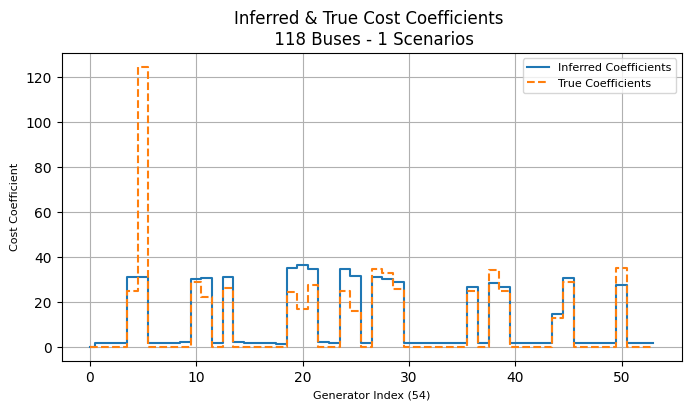

Scenario 1/5 generated.
Scenario 2/5 generated.
Scenario 3/5 generated.
Scenario 4/5 generated.
Scenario 5/5 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:30:26 PM: Your problem has 3929 variables, 17075 constraints, and 0 parameters.


/Users/don_williams09/opt/miniconda3/envs/opt_env/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) May 20 03:30:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:30:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 03:30:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 03:30:27 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 03:30:27 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 20 03:30:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) May 20 03:30:27 PM: Applying reduction Dcp2Cone
(CVXPY) May 20 03:30:29 PM: Applying reduction CvxAttr2Constr
(CVXPY) May 20 03:30:31 PM: Applyi

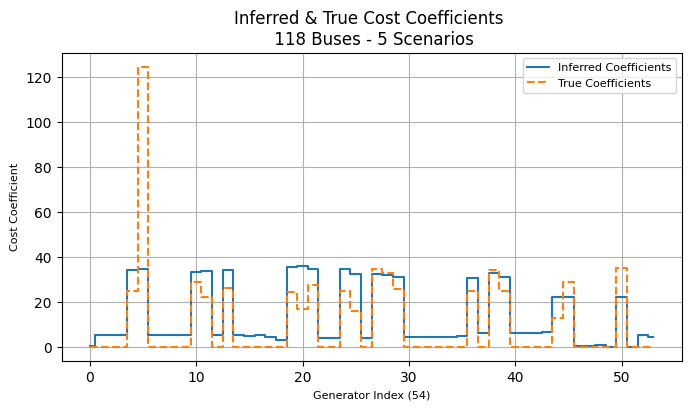

Scenario 1/10 generated.
Scenario 2/10 generated.
Scenario 3/10 generated.
Scenario 4/10 generated.
Scenario 5/10 generated.
Scenario 6/10 generated.
Scenario 7/10 generated.
Scenario 8/10 generated.
Scenario 9/10 generated.
Scenario 10/10 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:30:59 PM: Your problem has 7804 variables, 58150 constraints, and 0 parameters.
(CVXPY) May 20 03:31:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:31:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 03:31:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 03:31:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------

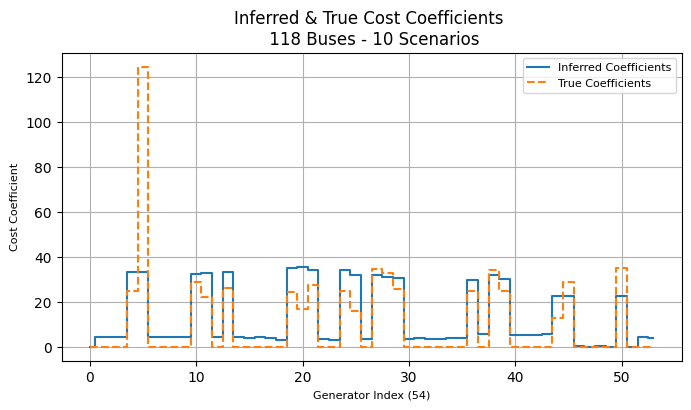

Scenario 1/15 generated.
Scenario 2/15 generated.
Scenario 3/15 generated.
Scenario 4/15 generated.
Scenario 5/15 generated.
Scenario 6/15 generated.
Scenario 7/15 generated.
Scenario 8/15 generated.
Scenario 9/15 generated.
Scenario 10/15 generated.
Scenario 11/15 generated.
Scenario 12/15 generated.
Scenario 13/15 generated.
Scenario 14/15 generated.
Scenario 15/15 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:32:40 PM: Your problem has 11679 variables, 123225 constraints, and 0 parameters.
(CVXPY) May 20 03:32:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:32:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 03:32:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 

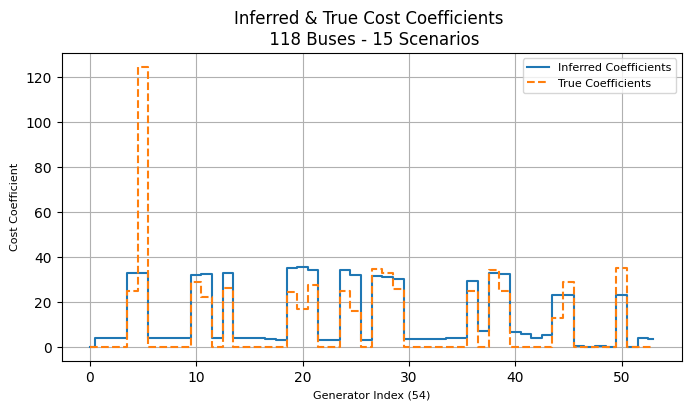

Scenario 1/20 generated.
Scenario 2/20 generated.
Scenario 3/20 generated.
Scenario 4/20 generated.
Scenario 5/20 generated.
Scenario 6/20 generated.
Scenario 7/20 generated.
Scenario 8/20 generated.
Scenario 9/20 generated.
Scenario 10/20 generated.
Scenario 11/20 generated.
Scenario 12/20 generated.
Scenario 13/20 generated.
Scenario 14/20 generated.
Scenario 15/20 generated.
Scenario 16/20 generated.
Scenario 17/20 generated.
Scenario 18/20 generated.
Scenario 19/20 generated.
Scenario 20/20 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:36:16 PM: Your problem has 15554 variables, 212300 constraints, and 0 parameters.
(CVXPY) May 20 03:36:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:36:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20

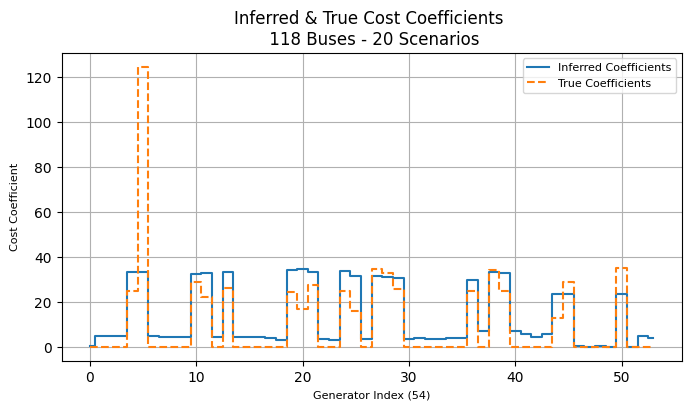

Scenario 1/25 generated.
Scenario 2/25 generated.
Scenario 3/25 generated.
Scenario 4/25 generated.
Scenario 5/25 generated.
Scenario 6/25 generated.
Scenario 7/25 generated.
Scenario 8/25 generated.
Scenario 9/25 generated.
Scenario 10/25 generated.
Scenario 11/25 generated.
Scenario 12/25 generated.
Scenario 13/25 generated.
Scenario 14/25 generated.
Scenario 15/25 generated.
Scenario 16/25 generated.
Scenario 17/25 generated.
Scenario 18/25 generated.
Scenario 19/25 generated.
Scenario 20/25 generated.
Scenario 21/25 generated.
Scenario 22/25 generated.
Scenario 23/25 generated.
Scenario 24/25 generated.
Scenario 25/25 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:42:45 PM: Your problem has 19429 variables, 325375 constraints, and 0 parameters.
(CVXPY) May 20 03:42:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 0

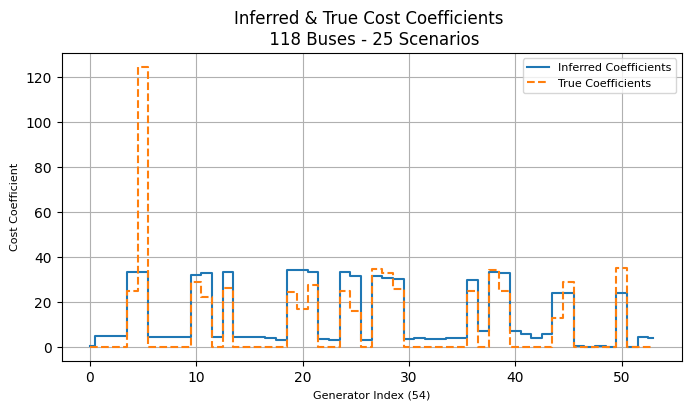

Scenario 1/30 generated.
Scenario 2/30 generated.
Scenario 3/30 generated.
Scenario 4/30 generated.
Scenario 5/30 generated.
Scenario 6/30 generated.
Scenario 7/30 generated.
Scenario 8/30 generated.
Scenario 9/30 generated.
Scenario 10/30 generated.
Scenario 11/30 generated.
Scenario 12/30 generated.
Scenario 13/30 generated.
Scenario 14/30 generated.
Scenario 15/30 generated.
Scenario 16/30 generated.
Scenario 17/30 generated.
Scenario 18/30 generated.
Scenario 19/30 generated.
Scenario 20/30 generated.
Scenario 21/30 generated.
Scenario 22/30 generated.
Scenario 23/30 generated.
Scenario 24/30 generated.
Scenario 25/30 generated.
Scenario 26/30 generated.
Scenario 27/30 generated.
Scenario 28/30 generated.
Scenario 29/30 generated.
Scenario 30/30 generated.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:54:44 PM: Your problem has 23304 variables, 462450 

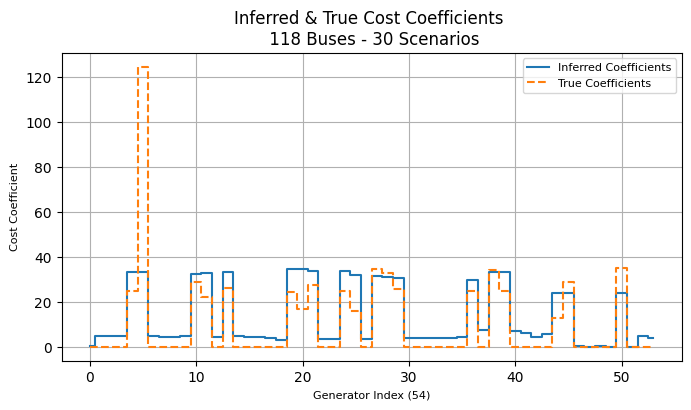

Scenario 1/35 generated.
Scenario 2/35 generated.
Scenario 3/35 generated.
Scenario 4/35 generated.
Scenario 5/35 generated.
Scenario 6/35 generated.
Scenario 7/35 generated.
Scenario 8/35 generated.
Scenario 9/35 generated.
Scenario 10/35 generated.
Scenario 11/35 generated.
Scenario 12/35 generated.
Scenario 13/35 generated.
Scenario 14/35 generated.
Scenario 15/35 generated.
Scenario 16/35 generated.
Scenario 17/35 generated.
Scenario 18/35 generated.
Scenario 19/35 generated.
Scenario 20/35 generated.
Scenario 21/35 generated.
Scenario 22/35 generated.
Scenario 23/35 generated.
Scenario 24/35 generated.
Scenario 25/35 generated.
Scenario 26/35 generated.
Scenario 27/35 generated.
Scenario 28/35 generated.
Scenario 29/35 generated.
Scenario 30/35 generated.
Scenario 31/35 generated.
Scenario 32/35 generated.
Scenario 33/35 generated.
Scenario 34/35 generated.
Scenario 35/35 generated.
                                     CVXPY                                     
                   

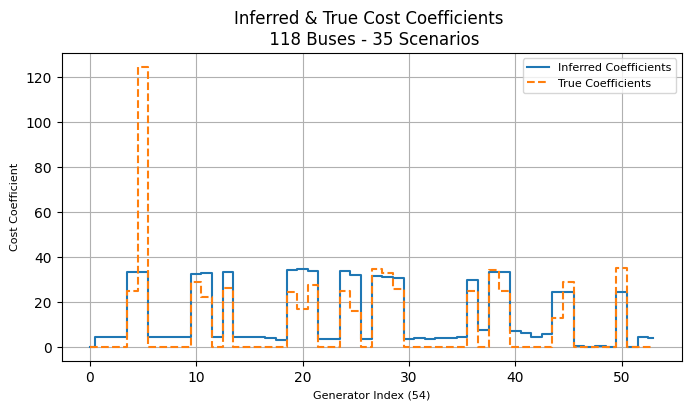

Scenario 1/40 generated.
Scenario 2/40 generated.
Scenario 3/40 generated.
Scenario 4/40 generated.
Scenario 5/40 generated.
Scenario 6/40 generated.
Scenario 7/40 generated.
Scenario 8/40 generated.
Scenario 9/40 generated.
Scenario 10/40 generated.
Scenario 11/40 generated.
Scenario 12/40 generated.
Scenario 13/40 generated.
Scenario 14/40 generated.
Scenario 15/40 generated.
Scenario 16/40 generated.
Scenario 17/40 generated.
Scenario 18/40 generated.
Scenario 19/40 generated.
Scenario 20/40 generated.
Scenario 21/40 generated.
Scenario 22/40 generated.
Scenario 23/40 generated.
Scenario 24/40 generated.
Scenario 25/40 generated.
Scenario 26/40 generated.
Scenario 27/40 generated.
Scenario 28/40 generated.
Scenario 29/40 generated.
Scenario 30/40 generated.
Scenario 31/40 generated.
Scenario 32/40 generated.
Scenario 33/40 generated.
Scenario 34/40 generated.
Scenario 35/40 generated.
Scenario 36/40 generated.
Scenario 37/40 generated.
Scenario 38/40 generated.
Scenario 39/40 genera

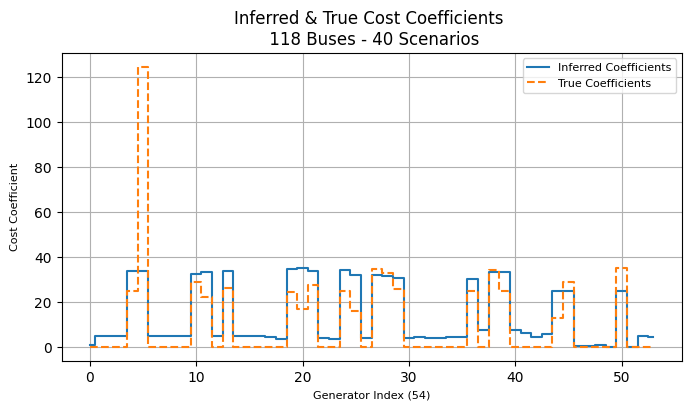

Scenario 1/45 generated.
Scenario 2/45 generated.
Scenario 3/45 generated.
Scenario 4/45 generated.
Scenario 5/45 generated.
Scenario 6/45 generated.
Scenario 7/45 generated.
Scenario 8/45 generated.
Scenario 9/45 generated.
Scenario 10/45 generated.
Scenario 11/45 generated.
Scenario 12/45 generated.
Scenario 13/45 generated.
Scenario 14/45 generated.
Scenario 15/45 generated.
Scenario 16/45 generated.
Scenario 17/45 generated.
Scenario 18/45 generated.
Scenario 19/45 generated.
Scenario 20/45 generated.
Scenario 21/45 generated.
Scenario 22/45 generated.
Scenario 23/45 generated.
Scenario 24/45 generated.
Scenario 25/45 generated.
Scenario 26/45 generated.
Scenario 27/45 generated.
Scenario 28/45 generated.
Scenario 29/45 generated.
Scenario 30/45 generated.
Scenario 31/45 generated.
Scenario 32/45 generated.
Scenario 33/45 generated.
Scenario 34/45 generated.
Scenario 35/45 generated.
Scenario 36/45 generated.
Scenario 37/45 generated.
Scenario 38/45 generated.
Scenario 39/45 genera

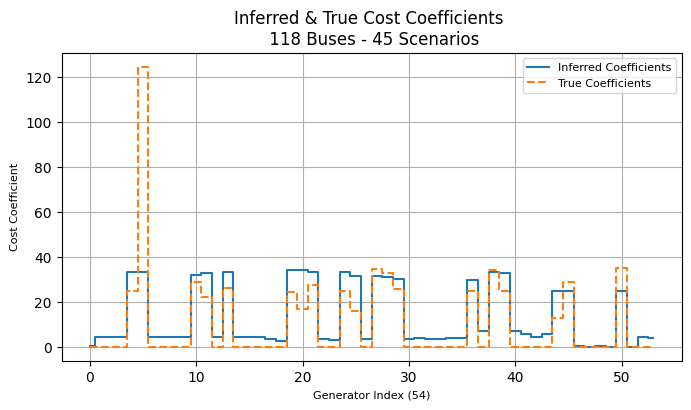

Scenario 1/50 generated.
Scenario 2/50 generated.
Scenario 3/50 generated.
Scenario 4/50 generated.
Scenario 5/50 generated.
Scenario 6/50 generated.
Scenario 7/50 generated.
Scenario 8/50 generated.
Scenario 9/50 generated.
Scenario 10/50 generated.
Scenario 11/50 generated.
Scenario 12/50 generated.
Scenario 13/50 generated.
Scenario 14/50 generated.
Scenario 15/50 generated.
Scenario 16/50 generated.
Scenario 17/50 generated.
Scenario 18/50 generated.
Scenario 19/50 generated.
Scenario 20/50 generated.
Scenario 21/50 generated.
Scenario 22/50 generated.
Scenario 23/50 generated.
Scenario 24/50 generated.
Scenario 25/50 generated.
Scenario 26/50 generated.
Scenario 27/50 generated.
Scenario 28/50 generated.
Scenario 29/50 generated.
Scenario 30/50 generated.
Scenario 31/50 generated.
Scenario 32/50 generated.
Scenario 33/50 generated.
Scenario 34/50 generated.
Scenario 35/50 generated.
Scenario 36/50 generated.
Scenario 37/50 generated.
Scenario 38/50 generated.
Scenario 39/50 genera

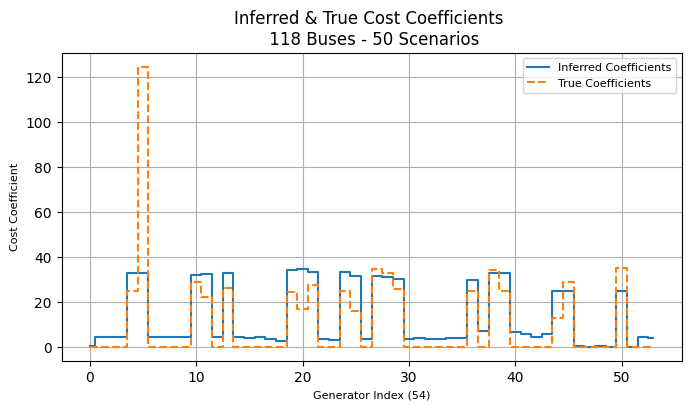

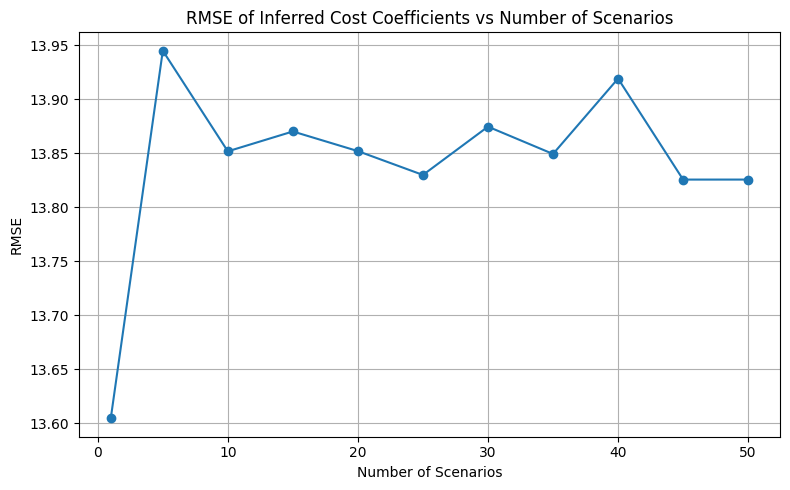

0

In [ ]:
test_scenario = [1, 5 , 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Number of scenarios to test
rmse_values = []

for test_num in test_scenario:
    # Storage for scenario data
    num_scenarios = test_num
    perturbation_scale = 0.25  # 25% perturbation
    Pg_scenarios = []
    lambda_slack_scenarios = []
    nu_max_scenarios = []
    nu_min_scenarios = []
    mu_min_scenarios = []
    mu_max_scenarios = []
    Pd_scenarios = []

    scenario_count = 0
    np.random.seed(42)

    while scenario_count < num_scenarios:
        Pd_perturbed = Pd_base * (1 + np.random.uniform(-perturbation_scale, perturbation_scale, size=num_buses))
        #Pd_perturbed = np.random.randint(0, 100, size=Pd_base.shape) + np.random.randint(0, 100, size=Pd_base.shape)/100
        Pd_perturbed[0] = 0  # slack bus
        Pd_scenarios.append(Pd_perturbed)
        
        Pg = cp.Variable(num_generators)
        P_inj = gen_to_bus @ Pg - Pd_perturbed
        
        # Exclude slack bus from PTDF
        indices = [i for i in range(num_buses) if i != id_to_index[slack]]
        P_inj_reduced = P_inj[indices]

        constraints = [
            cp.sum(Pg) == np.sum(Pd_perturbed),
            Pg >= Pg_min,
            Pg <= Pg_max,
            -branch_data_congested[:, 5] <= PTDF @ P_inj_reduced,
            PTDF @ P_inj_reduced <= branch_data_congested[:, 5]
        ]

        objective = cp.Minimize(cp.sum(cp.multiply(cost_coeff_true, Pg)))
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.MOSEK, verbose=False)

        if prob.status == 'optimal':
            scenario_count += 1
            Pg_scenarios.append(Pg.value)
            Pd_scenarios.append(Pd_perturbed)
            lambda_slack_scenarios.append(constraints[0].dual_value)
            nu_min_scenarios.append(constraints[3].dual_value)
            nu_max_scenarios.append(constraints[4].dual_value)
            mu_min_scenarios.append(constraints[1].dual_value)
            mu_max_scenarios.append(constraints[2].dual_value)
            print(f"Scenario {scenario_count}/{num_scenarios} generated.")

    Pg_scenarios = np.array(Pg_scenarios)
    lambda_slack_scenarios = np.array(lambda_slack_scenarios)
    nu_max_scenarios = np.array(nu_max_scenarios)
    nu_min_scenarios = np.array(nu_min_scenarios)
    mu_min_scenarios = np.array(mu_min_scenarios)
    mu_max_scenarios = np.array(mu_max_scenarios)

    # Inverse Optimization (using multiple scenarios)
    coef = cp.Variable(num_generators, nonneg=True)
    loss = 0
    BigM = 1e6

    Pg_inv = cp.Variable((num_scenarios, num_generators))
    lambda_slack_inv = cp.Variable(num_scenarios)   
    nu_min_inv = cp.Variable((num_scenarios, num_lines))
    nu_max_inv = cp.Variable((num_scenarios, num_lines))
    mu_min_inv = cp.Variable((num_scenarios, num_generators))
    mu_max_inv = cp.Variable((num_scenarios, num_generators))
    epsilon_line = cp.Variable((num_scenarios, num_lines))
    epsilon_gen = cp.Variable((num_scenarios, num_generators))

    constraints_inv = []
    stationarity = []
    primal_feasibility = []
    dual_feasibility = []
    complementary = []

    for t in range(num_scenarios):
        
        P_inj_inv = gen_to_bus @ Pg_inv[t] - Pd_scenarios[t]
        P_inj_reduced_inv = P_inj_inv[1:]
        flow_lines = PTDF @ P_inj_reduced_inv
        
        for gen in range(num_generators):
            # stationarity condition for generator
            stationarity.append(
                coef[gen] + lambda_slack_inv[t] + mu_max_inv[t][gen] - mu_min_inv[t][gen]      
                        + (nu_max_inv[t] - nu_min_inv[t]) @ PTDF @ gen_to_bus[1:, gen] == 0
            )
        
        primal_feasibility += [
            cp.sum(Pg_inv[t]) == np.sum(Pd_scenarios[t]),
            Pg_inv[t] >= Pg_min,
            Pg_inv[t] <= Pg_max,
            -branch_data[:, 5] <= flow_lines,
            flow_lines <= branch_data[:, 5]
        ]

        dual_feasibility += [
            mu_min_inv >= 0,
            mu_max_inv >= 0,
            nu_min_inv >= 0,
            nu_max_inv >= 0
        ]
        
        # Complementary slackness conditions
        for i in range(num_branches):
            # nu_min * (- branch_data_congested[:, 5] - PTDF @ P_inj_reduced) == 0
            if nu_min_scenarios[t][i] != 0:
                complementary.append(cp.abs(-branch_data_congested[i, 5] - flow_lines[i])<= epsilon_line[t][i])
                dual_feasibility.append(nu_max_inv[t][i] <= epsilon_line[t][i]) # check this
            # nu_max * (PTDF @ P_inj_reduced - branch_data_congested[:, 5]) == 0 
            elif nu_max_scenarios[t][i] != 0:
                complementary.append(cp.abs(flow_lines[i] - branch_data_congested[i, 5])<= epsilon_line[t][i])
                dual_feasibility.append(nu_min_inv[t][i] <= epsilon_line[t][i]) # check this
            else:     
                complementary.append(nu_min_inv[t][i] <= epsilon_line[t][i])
                complementary.append(nu_max_inv[t][i] <= epsilon_line[t][i])
            
        
        for i in range(num_generators):
            # mu_max * (Pg - Pg_max) == 0
            if Pg_scenarios[t][i] == Pg_max[i]:
                dual_feasibility.append(mu_max_inv[t][i] >= 0)
                dual_feasibility.append(mu_min_inv[t][i] <= epsilon_gen[t][i])
            # mu_min * (Pg_min - Pg) == 0
            elif Pg_scenarios[t][i] == Pg_min[i]:
                dual_feasibility.append(mu_min_inv[t][i] >= 0)
                dual_feasibility.append(mu_max_inv[t][i] <= epsilon_gen[t][i])
            else:
                dual_feasibility.append(mu_max_inv[t][i] <= epsilon_gen[t][i])
                dual_feasibility.append(mu_min_inv[t][i] <= epsilon_gen[t][i])
        
        # Loss function
        loss += cp.norm(Pg_inv[t] - Pg_scenarios[t], 2)**2
        loss += cp.norm(lambda_slack_inv[t] - lambda_slack_scenarios[t], 2)**2
        for i in range(num_generators):
            loss += cp.norm(mu_min_inv[t][i] - mu_min_scenarios[t][i], 2)**2
            loss += cp.norm(mu_max_inv[t][i] - mu_max_scenarios[t][i], 2)**2
            loss += epsilon_gen[t][i] * BigM
        for i in range(num_lines):      
            loss += cp.norm(nu_max_inv[t][i] - nu_max_scenarios[t][i], 2)**2
            loss += cp.norm(nu_min_inv[t][i] - nu_min_scenarios[t][i], 2)**2
            loss += epsilon_line[t][i] * BigM

    constraints_inv += stationarity + primal_feasibility  + dual_feasibility + complementary


    loss *= 1 / num_scenarios

    inv_prob = cp.Problem(cp.Minimize(loss), constraints_inv)
    inv_prob.solve(solver=cp.MOSEK, verbose=True)

    if inv_prob.status == 'optimal':
        print("Inferred cost coefficients: ", coef.value)
        print("True cost coefficients: ", cost_coeff_true)
        print("Optimal cost: ", inv_prob.value)
        rmse = np.sqrt(np.mean((coef.value - cost_coeff_true) ** 2))
        rmse_values.append(rmse)
    else:
        print("Inverse problem not optimal: ", inv_prob.status)

    plt.figure(figsize=(8, 4))

    # Plot inferred and real cost coefficients
    plt.step(range(len(coef.value)), coef.value, where='mid', label='Inferred Coefficients', linestyle='-')
    plt.step(range(len(cost_coeff_true)), cost_coeff_true, where='mid', label='True Coefficients', linestyle='--')

    # Add labels, legend, and title
    plt.xlabel(f"Generator Index ({num_generators})", fontsize=8)
    plt.ylabel('Cost Coefficient', fontsize=8)
    plt.title(f"Inferred & True Cost Coefficients \n {num_buses} Buses - {num_scenarios} Scenarios", fontsize=12)
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True)

    plt.savefig(f"/Users/don_williams09/Downloads/Bi_Level_Opt/plots/case{num_buses}_scen{num_scenarios}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# Second plot: RMSE vs number of scenarios
plt.figure(figsize=(8, 5))
plt.plot(test_scenario, rmse_values, marker='o', linestyle='-')
plt.title('RMSE of Inferred Cost Coefficients vs Number of Scenarios')
plt.xlabel('Number of Scenarios')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/Users/don_williams09/Downloads/Bi_Level_Opt/plots/rmse_curve_case{num_buses}.png", dpi=300, bbox_inches='tight')
plt.show()

# File path
test_scenario = [1, 5 , 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Number of scenarios to test
file_path = "/Users/don_williams09/Downloads/Bi_Level_Opt/results/rmse_results.pkl"

# Load existing results if the file exists
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        rmse_results = pickle.load(f)
else:
    rmse_results = {}

# Case name (you can dynamically create this)
case_name = f"case{num_buses}"

# Add or update the case entry
rmse_results[case_name] = {
    "scenarios": test_scenario,
    "rmse": rmse_values
}

# Save updated dictionary back to the file
with open(file_path, "wb") as f:
    pickle.dump(rmse_results, f)


os.system('say "Fini"')


print("Inferred cost coefficients: ", coef.value)
print("True cost coefficients: ", cost_coeff_true)

# Inverse Optimization Variables
print("loss:\n", loss.value)
print("Pg_inv:\n", Pg_inv.value)
print("lambda_slack_inv:\n", lambda_slack_inv.value)
print("nu_max_inv:\n", nu_max_inv.value)
print("nu_min_inv:\n", nu_min_inv.value)
print("mu_min_inv:\n", mu_min_inv.value)
print("mu_max_inv:\n", mu_max_inv.value)
print("epsilon_line:\n", epsilon_line.value)
print("epsilon_gen:\n", epsilon_gen.value)


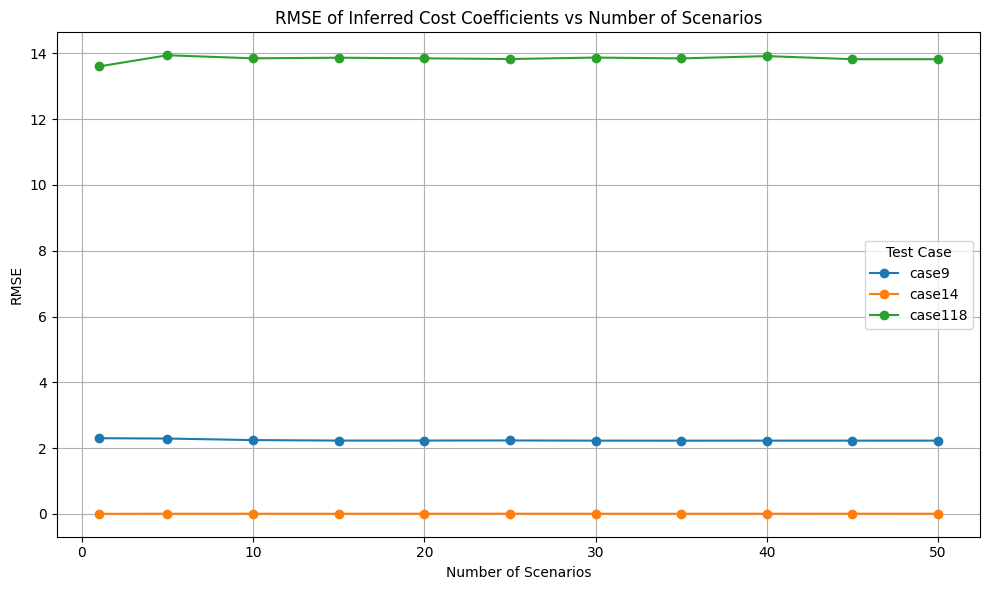

In [18]:
file_path = "/Users/don_williams09/Downloads/Bi_Level_Opt/results/rmse_results.pkl"

# Load the saved RMSE results
with open(file_path, "rb") as f:
    rmse_results = pickle.load(f)

# Create a plot for all test cases
plt.figure(figsize=(10, 6))
for case_name, data in rmse_results.items():
    plt.plot(data["scenarios"], data["rmse"], marker='o', label=case_name)

plt.xlabel("Number of Scenarios")
plt.ylabel("RMSE")
plt.title("RMSE of Inferred Cost Coefficients vs Number of Scenarios")
plt.grid(True)
plt.legend(title="Test Case")
plt.tight_layout()
plt.savefig(f"/Users/don_williams09/Downloads/Bi_Level_Opt/plots/rmse_curve_all_cases.png", dpi=300, bbox_inches='tight')
plt.show()


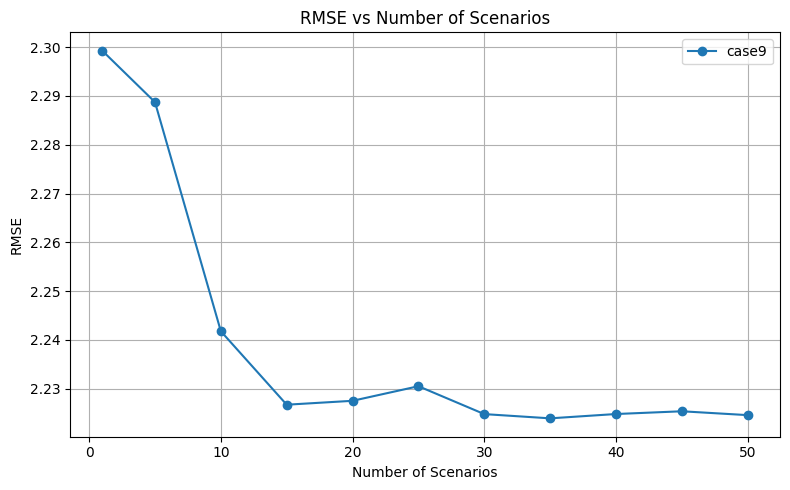

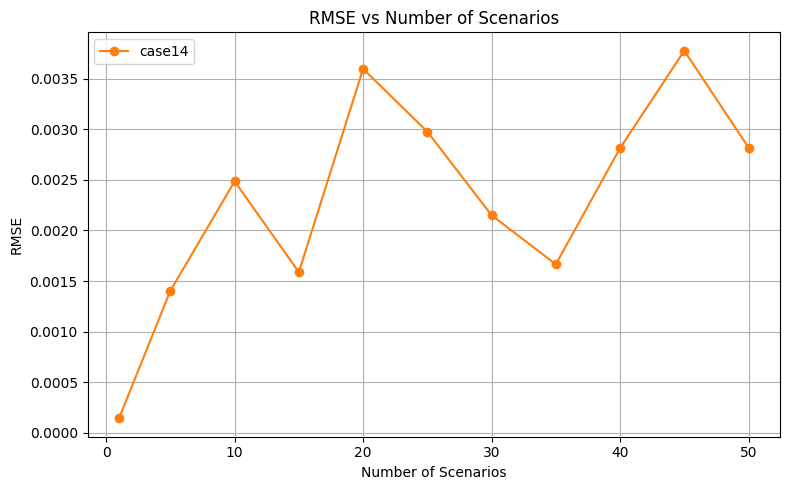

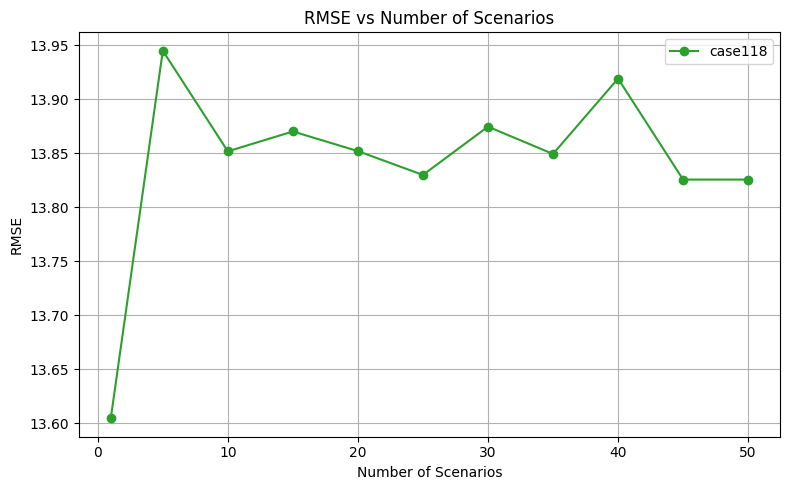

In [ ]:


file_path = "/Users/don_williams09/Downloads/Bi_Level_Opt/results/rmse_results.pkl"

true_cost_9 = [5,  1.2 ,1 ]
true_cost_14 = [ 7.920951, 23.269494,  0.,        0.,        0.,      ]
true_cost_118 = [  0.,         0.,         0.,         0.,        24.98342,  124.581564,
   0.,         0.,         0.,         0.,        28.948321,  22.22098,
   0.,        25.993982,   0.,         0. ,        0.,         0.,
   0.,        24.202306,  16.673942,  27.277343,   0.,         0.,
  24.861868,  16.056042,   0.,        34.781778 , 32.668781,  25.758442,
   0.,         0.,         0.,         0.,         0.,         0.,
  24.600772,   0.,        34.072633,  24.605102,   0.,         0.,
   0.,         0.,        12.61217,   28.649471 ,  0.,         0.,
   0.,         0.,        35.043401 ,  0.,         0.,         0.      ]

# Load the results
with open(file_path, "rb") as f:
    rmse_results = pickle.load(f)

# Predefined colors (blue, orange, green)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Plot separately with consistent colors
for idx, (case_key, data) in enumerate(rmse_results.items()):
    case_label = case_key.split("_")[0]  # "case14"
    color = colors[idx % len(colors)]   # Cycle through colors

    plt.figure(figsize=(8, 5))
    plt.plot(data["scenarios"], data["rmse"], marker='o', linestyle='-', color=color, label=case_label)
    plt.xlabel("Number of Scenarios")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs Number of Scenarios")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Optional: Save
    save_path = f"/Users/don_williams09/Downloads/Bi_Level_Opt/plots/{case_label}_rmse_plot.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


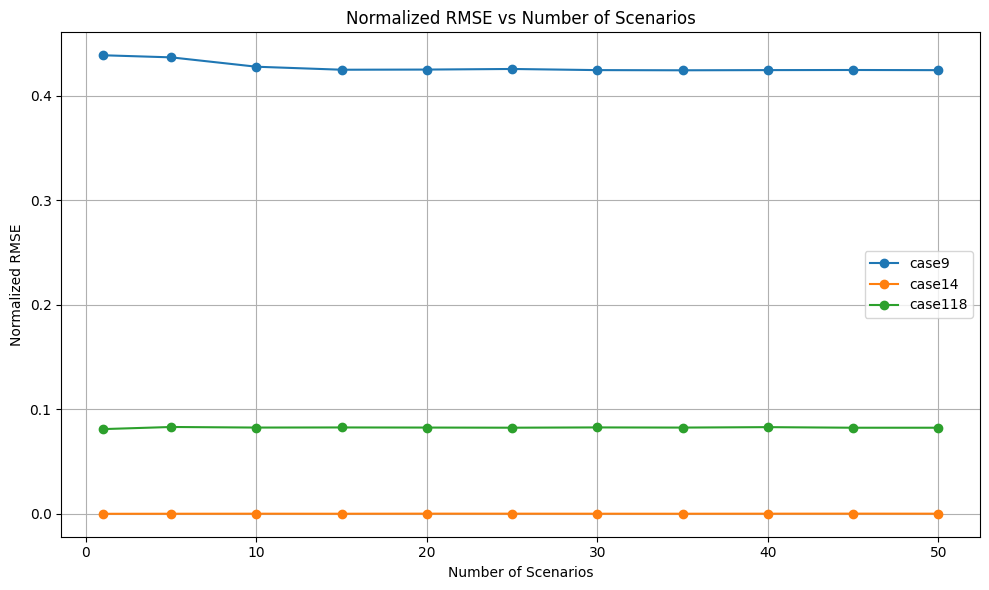

In [9]:
# Re-import necessary packages after code execution environment reset
import pickle
import matplotlib.pyplot as plt
import numpy as np

# File path and true cost coefficients
file_path = "/Users/don_williams09/Downloads/Bi_Level_Opt/results/rmse_results.pkl"

true_costs = {
    "case9": np.array([5, 1.2, 1]),
    "case14": np.array([7.920951, 23.269494, 0., 0., 0.]),
    "case118": np.array([
        0., 0., 0., 0., 24.98342, 124.581564, 0., 0., 0., 0., 28.948321, 22.22098,
        0., 25.993982, 0., 0., 0., 0., 0., 24.202306, 16.673942, 27.277343, 0., 0.,
        24.861868, 16.056042, 0., 34.781778, 32.668781, 25.758442, 0., 0., 0., 0., 0., 0.,
        24.600772, 0., 34.072633, 24.605102, 0., 0., 0., 0., 12.61217, 28.649471, 0., 0.,
        0., 0., 35.043401, 0., 0., 0.
    ])
}

# Load RMSE results
with open(file_path, "rb") as f:
    rmse_results = pickle.load(f)

# Compute and plot Normalized RMSE
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))

for idx, (case_key, data) in enumerate(rmse_results.items()):
    case_label = case_key.split("_")[0]
    true_coeffs = true_costs[case_label]
    norm_factor = np.linalg.norm(true_coeffs)

    norm_rmse = [rmse / norm_factor for rmse in data["rmse"]]
    
    plt.plot(data["scenarios"], norm_rmse, marker='o', linestyle='-', color=colors[idx], label=case_label)

plt.xlabel("Number of Scenarios")
plt.ylabel("Normalized RMSE")
plt.title("Normalized RMSE vs Number of Scenarios")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"/Users/don_williams09/Downloads/Bi_Level_Opt/plots/rmse_normalized_curve_all_cases.png", dpi=300, bbox_inches='tight')
plt.show()
